# Section 5: Extracting a region from mesh-based data

This section demonstrates regional extraction from a global mesh. This process is considerably more involved than with "structured" data like UM. For instance, UM data has data and coordinates with X and Y dimensions, corresponding to cell indices in the model arrays, and longitudes and latitudes of cells on the globe. Therefore, we can slice out a rectangular range of X and Y indices, e.g. my_datacube[..., 10:40, 4:77], and the result is some contiguous region of the globe within a defined range of latitude and longitude. The unstructured mesh does not visit locations on the globe in any particular, simple regular pattern. So crucially, a slice of data from the (now 1-D) arrays is not a contiguous geographical region as a contiguous region of the data is generally not contained in a contiguous range of data indices. See the [diagram](./LFRic_mesh.svg) from Section 02 showing numbering of nodes and faces around an LFRic cubesphere corner.

GeoVista supports the needed geographical calculations to extract mesh data within a required region. Here's an example of how to extract the mesh falling within a defined lat-lon region. As with the plotting example, there are no Iris utility functions for this, so user code is currently required to mediate between the Iris and Geovista/PyVista worlds.

## Load unstructured data and create Polydata object


Firts load some global LFRic data with the utility function `lfric_rh_datacube` from `testdata_fetching`

In [1]:
from testdata_fetching import lfric_rh_singletime_2d
lfric_rh = lfric_rh_singletime_2d()
#lfric_rh

/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/numpy/ma/core.py:502: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)
/home

As in the plotting [Section 03](./Sec_03_Plotting.ipynb) we create a Polydata object from the cube using the routine `pv_from_lfric_cube` from the package [pv_conversions](pv_conversions.py): 

In [2]:
from pv_conversions import pv_from_lfric_cube
pv_global_rh = pv_from_lfric_cube(lfric_rh)
#pv_global_rh

Uncommenting `lfric_rh` and `pv_global_rh` in the cells above allows you to print the loaded and converted data. 

## Enclose PolyData object in Bounding Box

Next import the needed GeoVista class `BBox` (short name for "Bounding Box"):

In [4]:
from geovista.geodesic import BBox

You can use the notebook "?" command to display the function signature of its constructor

In [5]:
?BBox.__init__

Signature:
BBox.__init__(
    self,
    lons: 'ArrayLike',
    lats: 'ArrayLike',
    ellps: 'str | None' = 'WGS84',
    c: 'int | None' = 256,
    triangulate: 'bool | None' = False,
) -> 'None'
Docstring:
Create 3-D geodesic bounding-box to extract enclosed mesh, lines or point.

The bounding-box region is specified in terms of its four corners, in
degrees of longitude and latitude. As the bounding-box is a geodesic, it
can only ever at most enclose half of an ellipsoid.

The geometry of the bounding-box may be specified as either an open or
closed longitude/latitude geometry i.e., 4 or 5 longitude/latitude values.

Parameters
----------
lons : ArrayLike
    The longitudes (degrees) of the bounding-box, in the half-closed interval
    ``[-180, 180)``. Note that, longitudes will be wrapped to this interval.
lats : ArrayLike
    The latitudes (degrees) of the bounding-box, in the closed interval
    ``[-90, 90]``.
ellps : str, optional
    The ellipsoid for geodesic calculations. See
 

Give the function `BBox` the arguments `lons` and `lats` which specify the points of a bounding rectangle:

In [6]:
lon_min = -15
lon_max = 55
lat_min = -5
lat_max = 35

bbox = BBox(lons=[lon_min, lon_max, lon_max, lon_min], lats=[lat_min, lat_min, lat_max, lat_max])

To apply the BBox to data we pass the PolyData object to the `enclosed` method of the Bounding Box: 

In [7]:
pv_regional_rh = bbox.enclosed(pv_global_rh)
#print(pv_regional_rh.n_cells)
#print(pv_regional_rh)

Uncomment the last line to print the enclsoed PolyData object `pv_regional_rh`. Compared to the global PolyData object `pv_global_rh` it has a smaller number of cells.

In [8]:
#print(pv_global_rh)
print(pv_global_rh.n_cells)

13824


### Plot extracted region

We are now plotting the extracted region and are adding coastlines (see [Sec_02 Plotting - Additional features](./Sec_03_Plotting.ipynb#Additional-features)) for reference:

/home/users/harley.kelly/.conda/envs/everyday/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


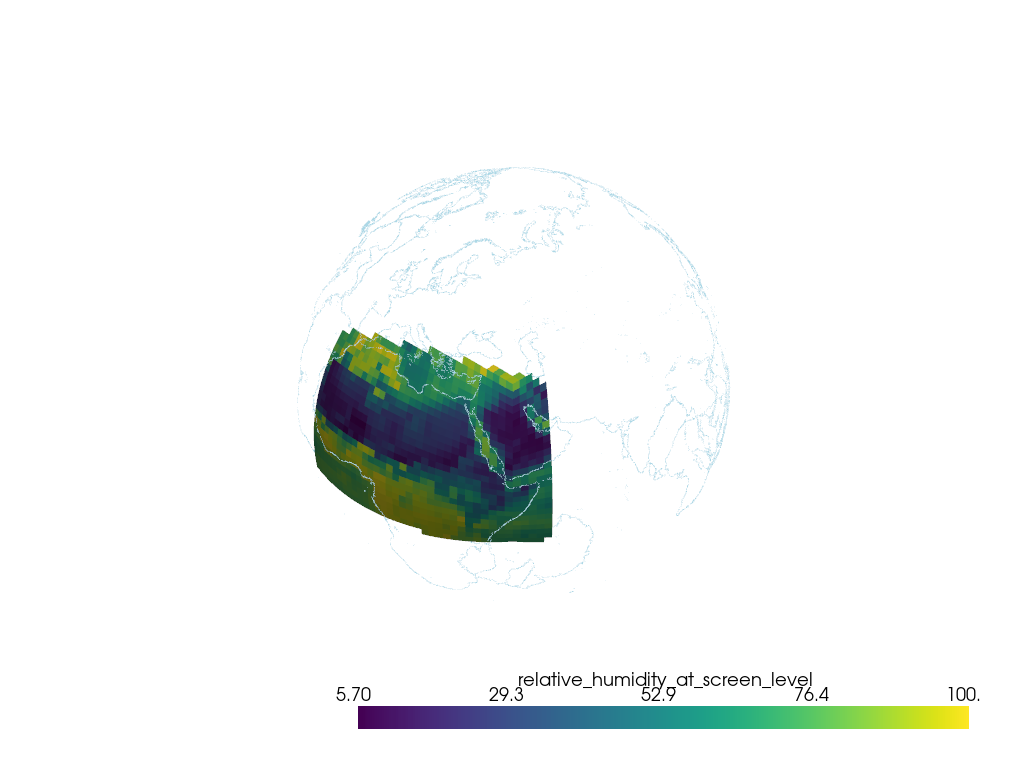

In [9]:
lon_min = -15
lon_max = 55
lat_min = -5
lat_max = 35

bbox = BBox(lons=[lon_min, lon_max, lon_max, lon_min], 
            lats=[lat_min, lat_min, lat_max, lat_max])

# The Bounding Box does not need to be a rectangle:
# bbox = BBox(lons=[lon_min, lon_max, lon_max, lon_min    ], 
#            lats=[lat_min, lat_min, lat_max, lat_max-20 ])

pv_regional_rh = bbox.enclosed(pv_global_rh) 

from geovista import GeoPlotter
plotter = GeoPlotter()
plotter.add_mesh(pv_regional_rh)
plotter.add_coastlines()
plotter.show()

Play with the longitude and latitude limits. Also, note that the Bounding Box does not need to be a rectangle as you could test above with `bbox = BBox(lons=[lon_min, lon_max, lon_max, lon_min],lats=[lat_min, lat_min, lat_max, lat_max-20])`.


## Get an Iris cube for an extracted region.

While GeoVista provides the efficient tools for mesh region extraction, it and Iris know nothing about one another. So, to calculate a regionally-extracted Iris cube, GeoVista can do the hard work of determining the subset of cells required, but you must then reconstruct an Iris cube from that information. For now, at least, there are no ready-made tools for this (in either Iris or Geovista). However, the operation is possible, and may be instructive. So, for those interested, there is an extra notebook [Bonus 03 MeshCube Extraction](./MeshCube_Extraction.ipynb), showing how this is done.


## Next notebooks

This is the end of the standard tutorial content. There is also some more detailed [bonus content](./Mesh_Tutorial_Intro.ipynb#bonus_and_additional_material) which you might be interested in.